In [1]:
import pickle
from utils import *
from model import *

Using TensorFlow backend.


In [2]:
# Load the processed data
with open('SVO.p', 'rb') as f:
    verbs, objects, relations, pairs, _ = pickle.load(f)

In [3]:
# Do some pre-train cleanup
relations = flatten(relations)
remove_dups(pairs)

In [4]:
# Instantiate the core model
base = base_model(num_verbs=len(verbs)+1, sentence_space=60)

## Base model
The base model accepts 2 (Verb, Object) tuples. Each tuple is converted to a vector sequence and passed through a recurrent function which outputs a phrasal embedding. The cosine distance of the two embeddings is computed, and then passed through a linear regression layer that predicts whether the two phrases are semantically close. 

![base_model](Base_model.svg)

In [5]:
# The model is rather shallow so just a few epochs should suffice
h = base.fit_generator(data_generator(verbs, objects, pairs, 
                                      random_chance = 0.5, return_signatures=False),
                       steps_per_epoch=100, nb_epoch=25, verbose=False)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=False, epochs=25, steps_per_epoch=100)`
  after removing the cwd from sys.path.


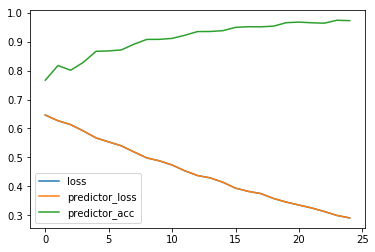

In [6]:
histplot(h.history)

In [ ]:
# Now instantiate the mapping model
mapper = mapping_model(base, sentence_space=60, num_verbs=len(verbs)+1, freeze=True,
                       embedding_activation='linear', lr=0.00005)

## Mapping model
The model extends the base model by accepting two additional inputs, the one-hot encodings of the two verbs. It (optionally) freezes the base model, disallowing further training of the recurrent and regression layers. The verb encodings are embedded to 2nd-order tensors. These, multiplied by the object vectors, produce a new pair of phrasal embeddings. 

The objective function is multi-fold; 
1. the recurrent and matmul embeddings need to **always** be classified as a paraphrase (for each of the two phrases),
2. the matmul embeddings of the two phrases need to be classified as a paraphrase depending on the training sample

![base_model](Embedding.svg)

In [ ]:
# Fitting the mapping model requires more negative samples, larger batch size, more epochs and a slower learning rate to get good results
g = mapper.fit_generator(data_generator(verbs, objects, pairs,
                                        random_chance=0.7, batch_size = 128, 
                                        return_signatures=True),
                         steps_per_epoch=100, nb_epoch=50, verbose=False)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=False, epochs=50, steps_per_epoch=100)`
  """


In [ ]:
histplot(g.history)